In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

# IO

In [2]:
casestore = dict()

In [3]:
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

toload = [
    dict(name="base", id="dyns2a-dyn_dens", unnormalise_geom = True),  
]

for case in toload:
    casestore[case["name"]] = Load.case_1D(db.casepaths[case["id"]])


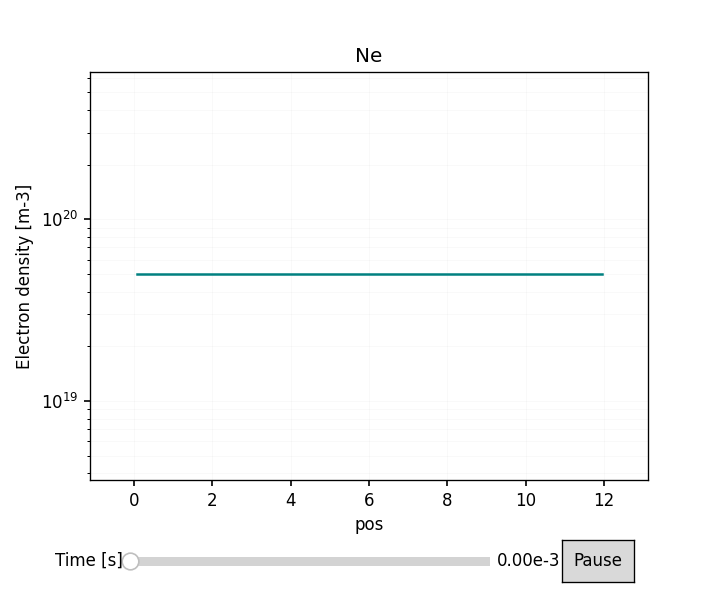

In [5]:
%matplotlib widget
plt.close("all")
ds = casestore["base"].ds.isel(pos=slice(2,-2))
fig, ax = plt.subplots()
anim = xbout.plotting.animate.animate_line(ds["Ne"], ax = ax)
ax.set_yscale("log")

# Pressure

In [9]:
ds["t"].values[-1]*1e6

1043.9684754508785

Text(0.5, 1.0, 'Dynamic density source test')

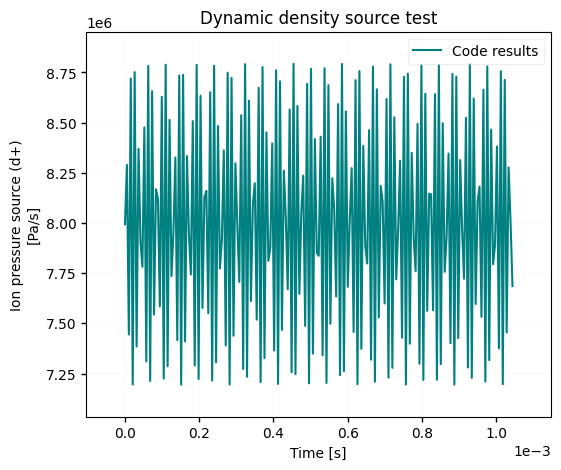

In [4]:
fig, ax = plt.subplots(dpi = 100)
ds = casestore["base"].ds.isel(pos=slice(2,-2))
m = ds.metadata
# fac = 1/(m["Nnorm"] * m["Omega_ci"])
# fac = 1
((ds["Pd+_src"]*3/2) * ds["dv"]).sum("pos").plot(ax = ax, label = "Code results")

# ax.plot(ds["t"], 0.5*16e6 * (1 + 0.10 * np.sin((2/0.5)*np.pi*1e6*ds["t"])), label = "Prescribed curve", lw = 0, marker="o")

ax.legend()
ax.set_title("Dynamic density source test")

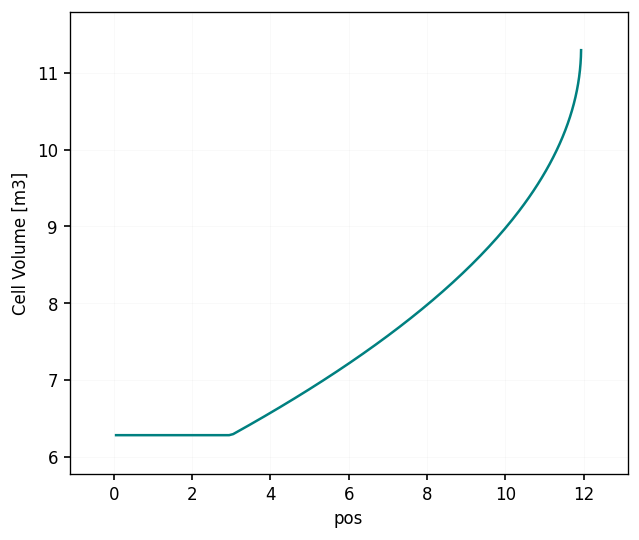

In [10]:
(ds["dv"]/ds["dy"]).plot()

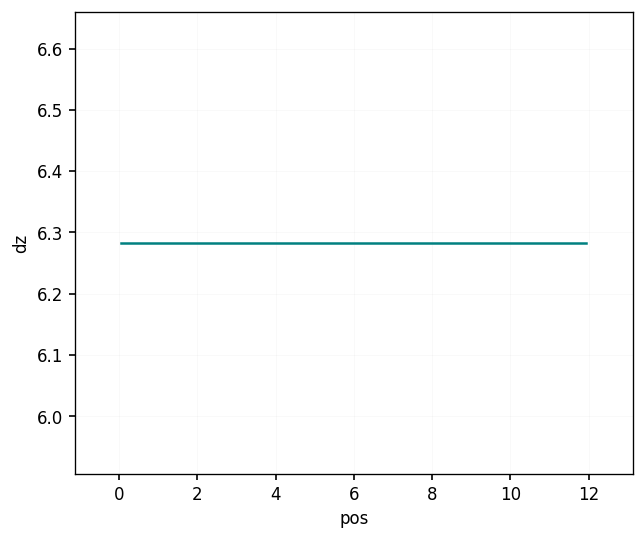

In [25]:
ds["dz"].plot()

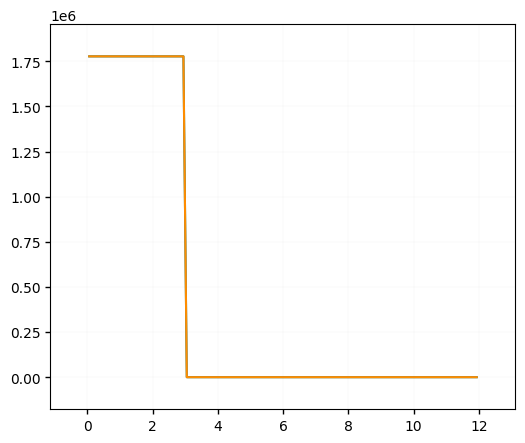

In [23]:
fig, ax = plt.subplots(dpi =100)

# powerflux = 16e6  # Input power flux in W/m^2
# source = 0.5 * (powerflux*2/3 / (mesh:length_xpt))*H(mesh:y_xpt - y)  # Input power as function of y

pos = ds["pos"].values
length_xpt = 3

powerflux = 16e6
src = 0.5 * (powerflux*2/3 / length_xpt) * np.heaviside(3-pos,0)
ax.plot(pos, src)
ax.plot(ds["pos"], ds["Pe_src"].isel(t=-1))

In [9]:
(ds.isel(t=0)["Pe_src"]*(3/2)*ds["dv"]).sum("pos").values * 1e-6

50.22719456179692

# Density oscillation

Text(0.5, 1.0, 'Dynamic density source test')

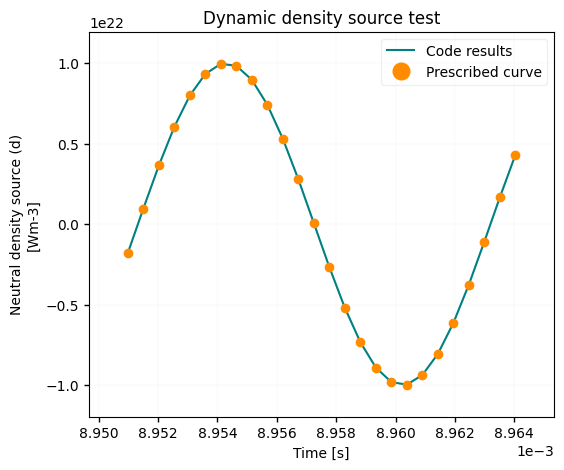

In [4]:
fig, ax = plt.subplots(dpi = 100)
ds = casestore["base"].ds.isel(pos=slice(2,-2))
m = ds.metadata
# fac = 1/(m["Nnorm"] * m["Omega_ci"])
fac = 1
(ds["Sd+_src"]*fac).isel(pos=0).plot(ax = ax, label = "Code results")

ax.plot(ds["t"], 1e22 * np.sin(4*np.pi*1e6*ds["t"]), label = "Prescribed curve", lw = 0, marker="o")

ax.legend()
ax.set_title("Dynamic density source test")

# Density dynamic source test

## Create waveform

In [23]:
np.pi

3.141592653589793

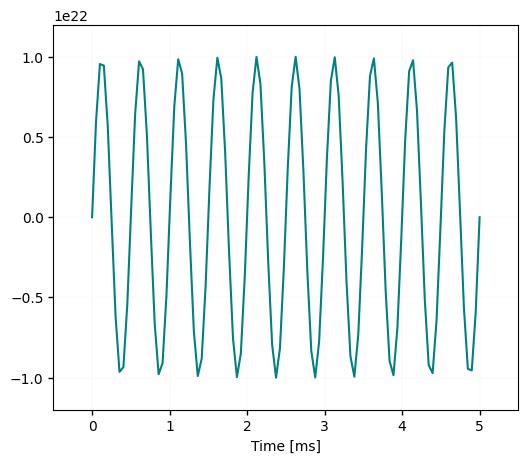

In [58]:
t = np.linspace(0, 5*1e-6, 100)
source = 1e22 * np.sin((2/0.5)*np.pi*1e6*t)

fig, ax = plt.subplots(dpi = 100)
ax.plot(t*1e6, source)
ax.set_xlabel("Time [ms]")
ax.set_label("Density source")

In [6]:
ds.data_vars

Data variables:
    Bxy                 (pos) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    Dd_Dpar             (t, pos) float64 dask.array<chunksize=(19, 50), meta=np.ndarray>
    Ed+_iz              (t, pos) float64 dask.array<chunksize=(19, 50), meta=np.ndarray>
    Ed+_rec             (t, pos) float64 dask.array<chunksize=(19, 50), meta=np.ndarray>
    Ed_Dpar             (t, pos) float64 dask.array<chunksize=(19, 50), meta=np.ndarray>
    Ed_target_recycle   (t, pos) float64 dask.array<chunksize=(19, 50), meta=np.ndarray>
    Edd+_cx             (t, pos) float64 dask.array<chunksize=(19, 50), meta=np.ndarray>
    EnergyFlow_d+_ylow  (t, pos) float64 dask.array<chunksize=(19, 50), meta=np.ndarray>
    EnergyFlow_e_ylow   (t, pos) float64 dask.array<chunksize=(19, 50), meta=np.ndarray>
    Fd+_iz              (t, pos) float64 dask.array<chunksize=(19, 50), meta=np.ndarray>
    Fd+_rec             (t, pos) float64 dask.array<chunksize=(19, 50), meta=np.ndarray>
    Fd_Dpar

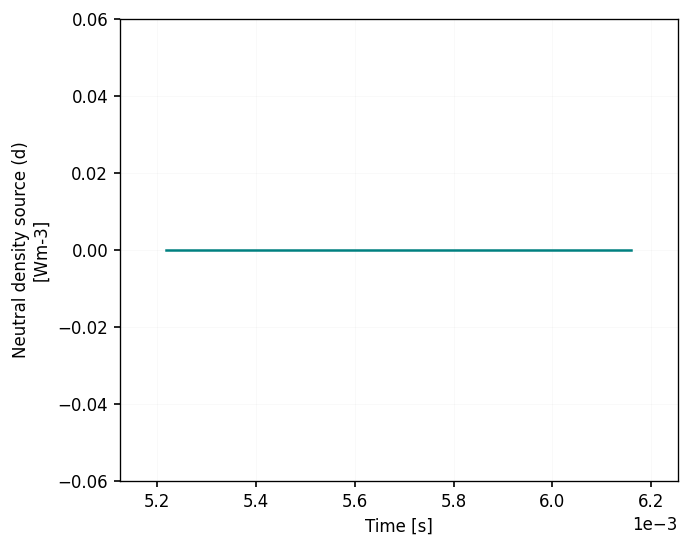

In [17]:
casestore["base"].ds["t"].values

array([0.00521984, 0.00527204, 0.00532424, 0.00537644, 0.00542864,
       0.00548083, 0.00553303, 0.00558523, 0.00563743, 0.00568963,
       0.00574183, 0.00579403, 0.00584622, 0.00589842, 0.00595062,
       0.00600282, 0.00605502, 0.00610722, 0.00615941])

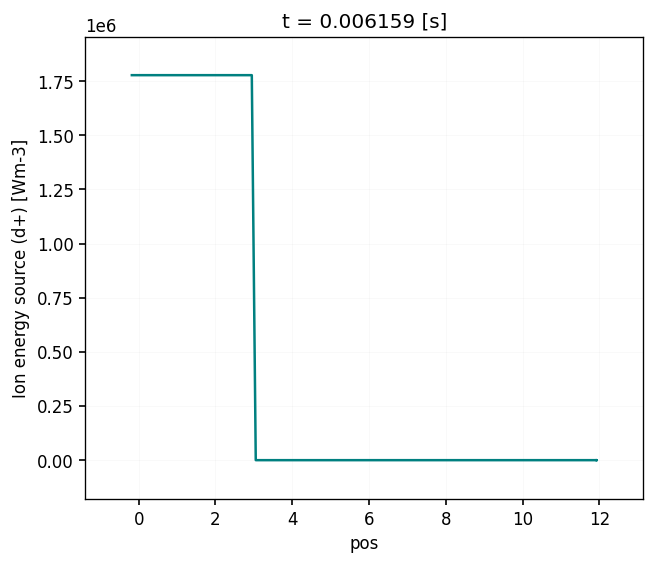

In [14]:
fig, ax = plt.subplots()
ds = casestore["base"].ds.isel(t=-1)

ds["Pd+_src"].plot(ax = ax)

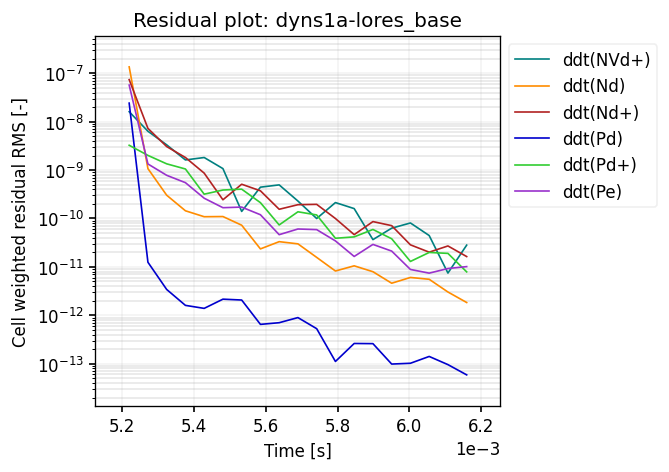

In [13]:
plot_ddt(casestore["base"])

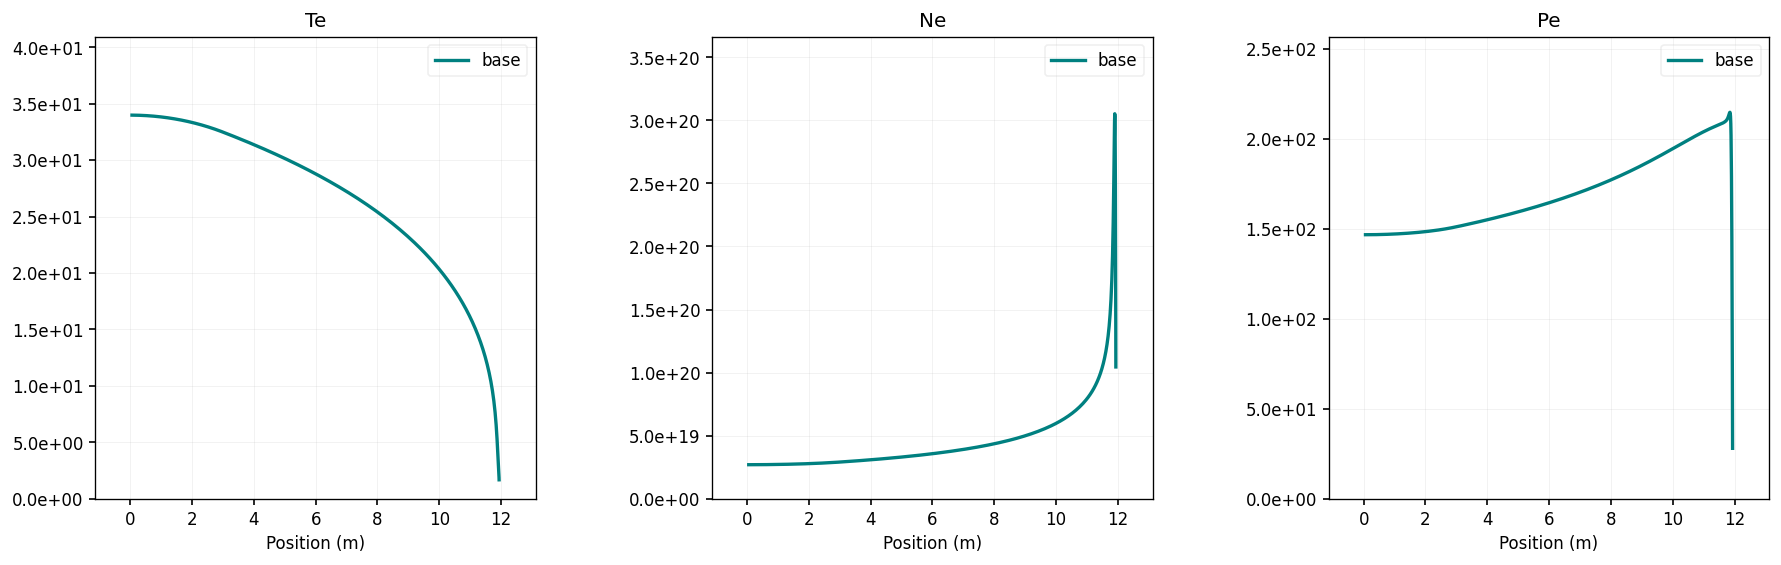

In [11]:
lw = 2
toplot = [ ["Te",  "Ne", "Pe"], 
        #   ["Ne", "Nd"]
          ]

for list_params in toplot:

    fig, axes = plt.subplots(1,3, figsize = (18,5))
    fig.subplots_adjust(wspace=0.4)

    for i, ax in enumerate(axes):
        param = list_params[i]
        for i, casename in enumerate(casestore): 
            ds = casestore[casename].ds.isel(pos=slice(2,-2), t = -1)
            ax.plot(ds["pos"], abs(ds[param]), linewidth = lw, label = casename, marker = "o", ms = 0)

        ax.set_xlabel("Position (m)")
        ax.set_title(param)
        ax.legend(fontsize = 10)
        ax.grid(which="major", alpha = 0.3)

        if param in list_params:
            ax.set_ylim(0,ax.get_ylim()[1]*1.1)
            # ax.set_xlim(9,10.5)

        ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.1e}"))
        

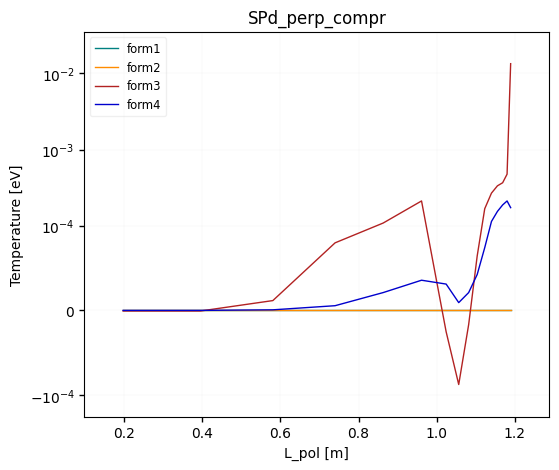

In [5]:
# locond = ['afnE', 'afnE_cond0.01', 'afnE_cond0.01_minmod_form1', 'afnE_cond0.01_minmod_form3', 'afnE_cond0.01_minmod_form2', 'afnE_cond0.25_form1', 'afnE_cond0.25_form2', 'afnE_cond0.25_form3', 'noafn_old', 'noafn_new']



fig, ax = plt.subplots(dpi = 100)
param = "SPd_perp_compr"
for i, case in enumerate(casestore):
    ds = casestore[case].ds
    if "t" in ds.dims.keys(): ds = ds.isel(t=-1)
    m = ds.metadata
    fl = ds.isel(x = m["ixseps1"], theta = slice(40,-2))
    dist = np.cumsum(fl["dl"])

    ax.plot(dist, fl[param], label = case,  lw = 1)

ax.set_yscale("symlog", linthresh = 1e-4)
ax.set_xlabel("L_pol [m]")
ax.set_ylabel("Temperature [eV]")
ax.set_title(param)
ax.legend(fontsize="small")

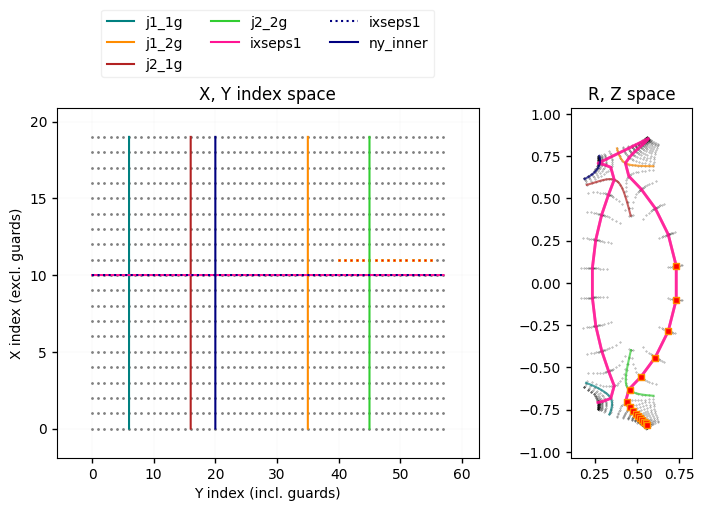

In [11]:
plot_selection(ds, ds.isel(x=11, theta = slice(40,-2)))

## Version E) 

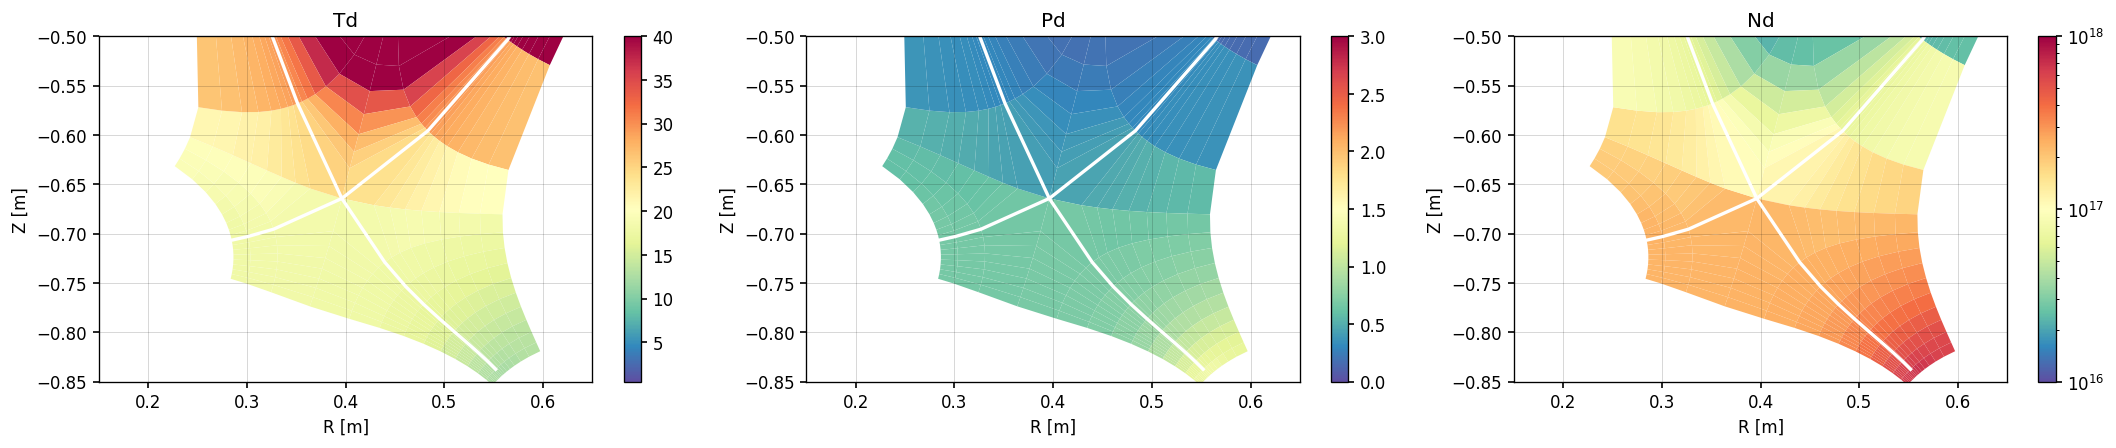

In [18]:
fig, axes = plt.subplots(1,3, dpi = 120, figsize = (18,3.5))

vmin = 0.5
vmax = 130
logscale = False

ds = casestore["form1"].ds.isel(t=-1,  theta=slice(2,-2))

data = ds["Td"]
data.hermesm.clean_guards().hermesm.polygon(ax = axes[0], cmap = "Spectral_r", vmin = vmin, vmax = 40, logscale = logscale, antialias = True, add_colorbar = True)
axes[0].set_title("Td")

data = ds["Pd"]
data.hermesm.clean_guards().hermesm.polygon(ax = axes[1], cmap = "Spectral_r", vmin = 0, vmax = 3, logscale = False, antialias = True, add_colorbar = True)
axes[1].set_title("Pd")

data = ds["Nd"]
data.hermesm.clean_guards().hermesm.polygon(ax = axes[2], cmap = "Spectral_r", vmin = 1e16, vmax = 1e18, logscale = True, antialias = True, add_colorbar = True)
axes[2].set_title("Nd")


for ax in axes:
    ax.set_ylim(-0.85, -0.5)
    ax.set_xlim(0.15,0.65)
    ax.grid(alpha = 0.3, c = "k")
    ax.set_xlabel("R [m]")
    ax.set_ylabel("Z [m]")
fig.tight_layout()